In [1]:
# Import necessary libraries
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(str(Path('../src').resolve().parent))
from src.models.recommender import GameRecommender
from src.data.load_dataset import get_train_data, get_test_data, get_games_data
from src.config.settings import FUNK_SVD_MODEL_DIR


In [2]:
# Load data and initialize recommender
train_data = get_train_data()
test_data = get_test_data()
games_data = get_games_data()

instance = GameRecommender(train_data, games_data)
instance.load(FUNK_SVD_MODEL_DIR)

# Get the initial state data
initial_users_count = len(instance.model.user_ids)
initial_items_count = len(instance.model.item_ids)
initial_train_data_size = len(instance.train_data)

print(f"Initial model state:")
print(f"- Number of users: {initial_users_count}")
print(f"- Number of items: {initial_items_count}")
print(f"- Training data size: {initial_train_data_size}")


2025-04-23 23:03:04.756 | DEBUG    | src.models.funk_svd:load_model:291 - Loading models from C:\Ukma\coursework\funk-svd\data\models\funk_svd


Initial model state:
- Number of users: 961
- Number of items: 11879
- Training data size: 81142


In [10]:
# Test case 1: Add a new user with some sample ratings
new_user_ratings = [
    {'BGGId': 174430, 'Rating': 8.5},  # Gloomhaven
    {'BGGId': 167791, 'Rating': 7.0},  # Terraforming Mars
    {'BGGId': 233078, 'Rating': 9.0},  # Wingspan
    {'BGGId': 169786, 'Rating': 6.5},  # Scythe
]

# Add the new user and get their ID
success, new_user_id, is_new_user = instance.add_ratings(new_user_ratings)
print(f"Added new user with ID: {new_user_id} (New user: {is_new_user}, Update successful: {success})")

# Verify internal training data was updated
updated_train_data_size = len(instance.train_data)
print(f"Training data size after adding new user: {updated_train_data_size}")
print(f"New ratings added: {updated_train_data_size - initial_train_data_size}")

# Get recommendations for the new user
attributes = ['Name', 'YearPublished', 'AvgRating', 'NumUserRatings',
              'Rank:boardgame']
recommendations = instance.get_recommendations(
    user_id=new_user_id,
    n=10,
    attributes=attributes
)

# Display recommendations
pd.DataFrame(recommendations)


2025-04-21 21:24:24.817 | INFO     | src.models.funk_svd:add_or_get_user:228 - Added new user 344220 with index 960. Initial bias: -0.1878
2025-04-21 21:24:24.827 | DEBUG    | src.recommender:_update_internal_train_data:112 - Updated internal training data. New size: 81146
2025-04-21 21:24:24.829 | INFO     | src.models.funk_svd:update_with_ratings:282 - Performing incremental SGD update with 4 ratings (including potential new users/items)...
2025-04-21 21:24:24.831 | INFO     | src.models.funk_svd:update_with_ratings:300 - Incremental SGD update completed. Final RMSE on batch for last factor: 1.1293


Added new user with ID: 344220 (New user: True, Update successful: True)
Training data size after adding new user: 81146
New ratings added: 4


,BGGId,PredictedRating,Name,YearPublished,AvgRating,NumUserRatings,Rank:boardgame
0,266507,9.018401,Clank!: Legacy – Acquisitions Incorporated,2019,8.69604,4722,34
1,246900,8.943039,Eclipse: Second Dawn for the Galaxy,2020,8.67526,4996,46
2,284378,8.793891,Kanban EV,2020,8.62853,2791,139
3,224517,8.776693,Brass: Birmingham,2018,8.66562,24849,3
4,270633,8.776011,Aeon's End: The New Age,2019,8.67759,1725,376
5,291457,8.747990,Gloomhaven: Jaws of the Lion,2020,8.69610,15062,6
6,55690,8.731164,Kingdom Death: Monster,2015,8.61012,8012,50
7,169427,8.722347,Middara: Unintentional Malum – Act 1,2019,8.84724,1544,545
8,161936,8.719939,Pandemic Legacy: Season 1,2015,8.59678,44614,2
9,251247,8.647053,Barrage,2019,8.22651,9161,43


In [11]:
# Test case 2: Add new ratings for an existing user
# First, let's select an existing user ID from the dataset
existing_user_id = train_data['UserId'].iloc[0]
print(f"Selected existing user ID: {existing_user_id}")

# Get current recommendations for this user
print("\nCurrent recommendations for existing user:")
existing_recommendations = instance.get_recommendations(
    user_id=existing_user_id,
    n=5,
    attributes=attributes
)
for i, rec in enumerate(existing_recommendations, 1):
    print(f"{i}. {rec['Name']} ({rec['YearPublished']}) - Predicted Rating: {rec['PredictedRating']:.2f}")

# Add new ratings for this existing user
new_ratings_for_existing = [
    {'BGGId': 284378, 'Rating': 3.5},  # Kanban EV
    {'BGGId': 224517, 'Rating': 2.0},  # Brass: Birmingham
    {'BGGId': 270633, 'Rating': 9.5},  # Aeon's End: The New Age
]

# Before-update training data size
before_update_size = len(instance.train_data)

# Update the user with new ratings
success, user_id, is_new_user = instance.add_ratings(new_ratings_for_existing, existing_user_id)
print(f"\nAdded new ratings for existing user {user_id} (New user: {is_new_user}, Update successful: {success})")

# After-update training data size
after_update_size = len(instance.train_data)
print(f"Training data size changed from {before_update_size} to {after_update_size}")

# Get updated recommendations for this user
print("\nUpdated recommendations for existing user:")
updated_recommendations = instance.get_recommendations(
    user_id=existing_user_id,
    n=5,
    attributes=attributes
)
for i, rec in enumerate(updated_recommendations, 1):
    print(f"{i}. {rec['Name']} ({rec['YearPublished']}) - Predicted Rating: {rec['PredictedRating']:.2f}")


Selected existing user ID: 26

Current recommendations for existing user:


2025-04-21 21:24:25.063 | DEBUG    | src.recommender:_update_internal_train_data:112 - Updated internal training data. New size: 81149
2025-04-21 21:24:25.065 | INFO     | src.models.funk_svd:update_with_ratings:282 - Performing incremental SGD update with 3 ratings (including potential new users/items)...
2025-04-21 21:24:25.068 | INFO     | src.models.funk_svd:update_with_ratings:300 - Incremental SGD update completed. Final RMSE on batch for last factor: 4.3164


1. Clank!: Legacy – Acquisitions Incorporated (2019) - Predicted Rating: 8.63
2. Eclipse: Second Dawn for the Galaxy (2020) - Predicted Rating: 8.53
3. Kanban EV (2020) - Predicted Rating: 8.36
4. Aeon's End: The New Age (2019) - Predicted Rating: 8.33
5. Middara: Unintentional Malum – Act 1 (2019) - Predicted Rating: 8.30

Added new ratings for existing user 26 (New user: False, Update successful: True)
Training data size changed from 81146 to 81149

Updated recommendations for existing user:
1. Clank!: Legacy – Acquisitions Incorporated (2019) - Predicted Rating: 8.39
2. Eclipse: Second Dawn for the Galaxy (2020) - Predicted Rating: 8.29
3. Middara: Unintentional Malum – Act 1 (2019) - Predicted Rating: 8.06
4. Gloomhaven: Jaws of the Lion (2020) - Predicted Rating: 8.05
5. Kingdom Death: Monster (2015) - Predicted Rating: 8.01


In [ ]:
# Test case 3: Add ratings for a completely new item not in the original dataset
# Let's create a synthetic new game that wasn't in the original training set
# We'll need to ensure it's not in the original dataset
max_existing_id = max(instance.model.item_ids)
new_game_id = max_existing_id + 1000  # Ensuring it's not in the dataset

# Check if the item is truly new
print(f"New game ID: {new_game_id}")
print(f"Is this item in the model? {new_game_id in instance.model.item_id_to_idx}")

# Create a fake new game
new_game_ratings = [
    {'BGGId': new_game_id, 'Rating': 9.0}  # A new game with a high rating
]

# First, let's check the prediction stability for our test user before adding the new game
before_predictions = instance.get_predictions(existing_user_id)
sample_items = list(before_predictions.keys())[:5]
print("\nPredictions for sample items before adding new game:")
for item_id in sample_items:
    game_name = instance.games_data.get(int(item_id), {}).get('Name', f'Game {item_id}')
    print(f"{game_name}: {before_predictions[item_id]:.2f}")

# Record the number of items before the update
before_items_count = len(instance.model.item_ids)

# Add ratings for the new game
success, user_id, is_new_user = instance.add_ratings(new_game_ratings, existing_user_id)
print(f"\nAdded rating for new game (ID: {new_game_id}) for user {user_id}")
print(f"Update successful: {success}")

# Record the number of items after the update
after_items_count = len(instance.model.item_ids)
print(f"Number of items changed from {before_items_count} to {after_items_count}")

# Verify the new item was added to the models
print(f"Is the new game now in the model? {new_game_id in instance.model.item_id_to_idx}")
if new_game_id in instance.model.item_id_to_idx:
    new_item_idx = instance.model.item_id_to_idx[new_game_id]
    print(f"New game index in the model: {new_item_idx}")
    print(f"New game bias: {instance.model.i_bias[new_item_idx]:.4f}")

# Check if predictions for other items remained stable
after_predictions = instance.get_predictions(existing_user_id)
print("\nPredictions for sample items after adding new game:")
for item_id in sample_items:
    game_name = instance.games_data.get(int(item_id), {}).get('Name', f'Game {item_id}')
    print(f"{game_name}: {after_predictions[item_id]:.2f}")
    delta = after_predictions[item_id] - before_predictions[item_id]
    print(f"  Change: {delta:.4f}")


In [ ]:
# Test case 4: Test incremental learning with multiple batches
# Let's simulate multiple updates with different ratings and track the changes

user_id = existing_user_id
print(f"Testing incremental learning for user {user_id}")

# Get initial recommendations as baseline
initial_recs = instance.get_recommendations(user_id, n=3, attributes=['Name'])
print("\nInitial top recommendations:")
initial_recs_df = pd.DataFrame(initial_recs)[['Name', 'PredictedRating']]
print(initial_recs_df)

# Create 3 batches of ratings with some consistent preferences
batches = [
    # Batch 1: Add ratings for strategy games
    [
        {'BGGId': 31260, 'Rating': 9.0},  # Agricola
        {'BGGId': 84876, 'Rating': 9.2},  # The Castles of Burgundy
    ],
    # Batch 2: Add ratings for more strategy games
    [
        {'BGGId': 12333, 'Rating': 8.8},  # Twilight Struggle
        {'BGGId': 35677, 'Rating': 8.5},  # Le Havre
    ],
    # Batch 3: Add even more strategy-focused ratings
    [
        {'BGGId': 25613, 'Rating': 8.9},  # Through the Ages
        {'BGGId': 124361, 'Rating': 9.3},  # Concordia
    ]
]

# Process each batch and track changes to recommendations
all_recommendations = [initial_recs_df]

for i, batch in enumerate(batches, 1):
    print(f"\nProcessing batch {i} with {len(batch)} ratings...")
    success, _, _ = instance.add_ratings(batch, user_id)
    
    # Get updated recommendations
    updated_recs = instance.get_recommendations(user_id, n=3, attributes=['Name'])
    updated_recs_df = pd.DataFrame(updated_recs)[['Name', 'PredictedRating']]
    all_recommendations.append(updated_recs_df)


# Compare all batches of recommendations side by side
print("\nComparing recommendations across batches:")
for i, recs_df in enumerate(all_recommendations):
    batch_name = "Initial" if i == 0 else f"After Batch {i}"
    print(f"\n{batch_name}:")
    print(recs_df)


C:\Users\denis\AppData\Local\Temp\ipykernel_26296\3455579405.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rating = float(recs_df[recs_df['Name'] == game]['PredictedRating'])


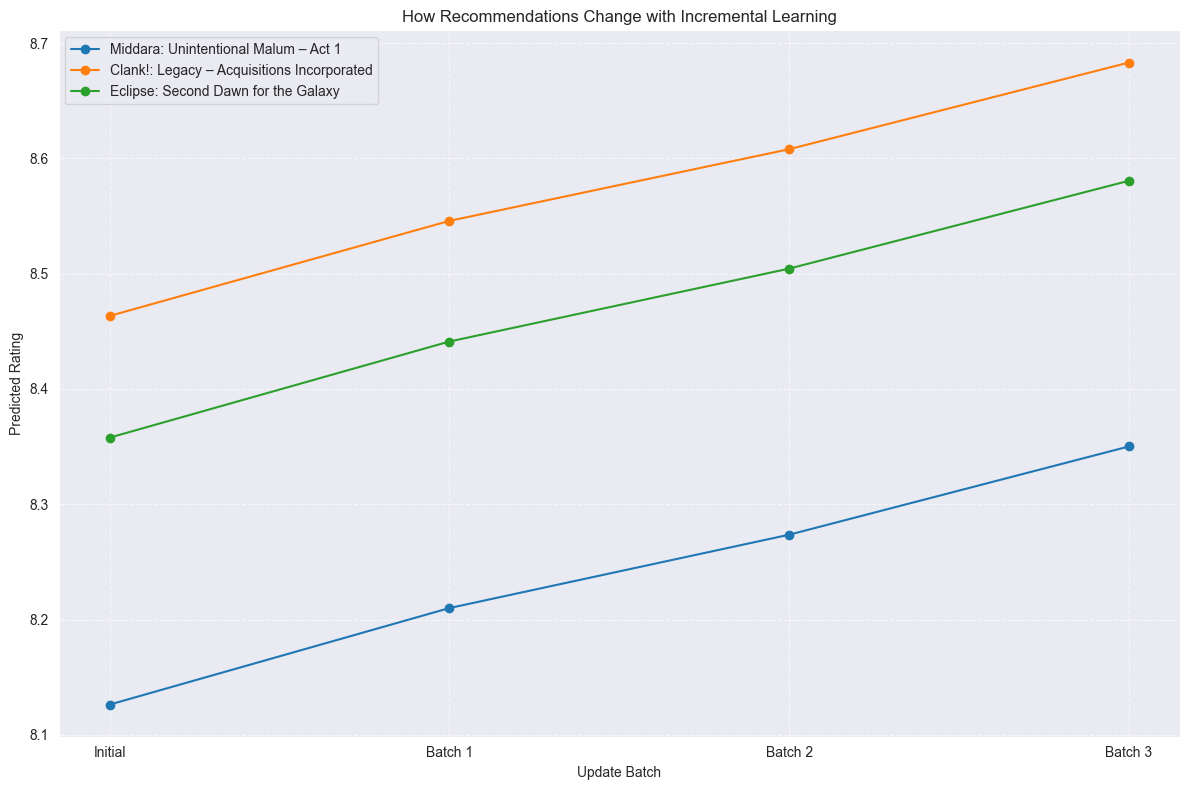

Incremental learning test completed successfully!


In [14]:
# Visualize how predictions change with incremental learning
# Extract all games that appeared in any recommendation list
all_recommended_games = set()
for recs_df in all_recommendations:
    all_recommended_games.update(recs_df['Name'])

# Create a DataFrame tracking prediction changes for each game
prediction_history = {game: [] for game in all_recommended_games}

for recs_df in all_recommendations:
    for game in all_recommended_games:
        if game in recs_df['Name'].values:
            rating = float(recs_df[recs_df['Name'] == game]['PredictedRating'])
            prediction_history[game].append(rating)
        else:
            prediction_history[game].append(None)  # Game wasn't in this recommendation set

# Plot the changes over time
plt.figure(figsize=(12, 8))
x = range(len(all_recommendations))
batch_labels = ["Initial"] + [f"Batch {i}" for i in range(1, len(all_recommendations))]

for game, ratings in prediction_history.items():
    # Convert None values to NaN for plotting
    ratings_np = np.array([r if r is not None else np.nan for r in ratings])
    plt.plot(x, ratings_np, marker='o', label=game)

plt.xticks(x, batch_labels)
plt.xlabel('Update Batch')
plt.ylabel('Predicted Rating')
plt.title('How Recommendations Change with Incremental Learning')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

print("Incremental learning test completed successfully!")
